In [3]:
# Install Kaggle package
!pip install -q kaggle

# Upload your Kaggle API JSON file
from google.colab import files
files.upload()

# Create a directory for Kaggle and move your kaggle.json file there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset from Kaggle (Replace <dataset-identifier> with the actual dataset identifier)
!kaggle datasets download -d mariafrenti/age-prediction

# Unzip the dataset (Replace <dataset-name>.zip with the actual zip file name)
!unzip age-prediction.zip


Streaming output truncated to the last 5000 lines.
  inflating: age_prediction_up/age_prediction/train/070/78007.jpg  
  inflating: age_prediction_up/age_prediction/train/070/78332.jpg  
  inflating: age_prediction_up/age_prediction/train/070/78495.jpg  
  inflating: age_prediction_up/age_prediction/train/070/78603.jpg  
  inflating: age_prediction_up/age_prediction/train/070/78950.jpg  
  inflating: age_prediction_up/age_prediction/train/070/79193.jpg  
  inflating: age_prediction_up/age_prediction/train/070/79502.jpg  
  inflating: age_prediction_up/age_prediction/train/070/79589.jpg  
  inflating: age_prediction_up/age_prediction/train/070/79660.jpg  
  inflating: age_prediction_up/age_prediction/train/070/79733.jpg  
  inflating: age_prediction_up/age_prediction/train/070/79774.jpg  
  inflating: age_prediction_up/age_prediction/train/070/80028.jpg  
  inflating: age_prediction_up/age_prediction/train/070/80607.jpg  
  inflating: age_prediction_up/age_prediction/train/070/81012.jpg

In [2]:
#!pip install -q tensorflow==2.17.0
import tensorflow as tf
print(tf.__version__)

2.17.0


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
from glob import glob

# Paths to the dataset
train_dir = '/content/20-50/20-50/train'  # Replace with actual train directory path
test_dir = '/content/20-50/20-50/test'    # Replace with actual test directory path

# Count the number of images in the dataset
num_train_images = len(glob(train_dir + '/*/*.jpg'))
num_test_images = len(glob(test_dir + '/*/*.jpg'))
print(f"Number of training images: {num_train_images}")
print(f"Number of testing images: {num_test_images}")

# Data generators for training and testing
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)


Number of training images: 33432
Number of testing images: 7008
Found 26757 images belonging to 31 classes.
Found 6675 images belonging to 31 classes.
Found 7008 images belonging to 31 classes.


In [4]:
# Choose between ResNet50 or EfficientNetB0
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# or
# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1)(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [5]:
# Model checkpoint to save best weights
checkpoint = ModelCheckpoint('best_model.weights.h5', monitor='val_mae', save_best_only=True, save_weights_only=True)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_mae', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)

# Load the best weights
model.load_weights('best_model.weights.h5')


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


837/837 ━━━━━━━━━━━━━━━━━━━━ 135s 146ms/step - loss: 83.6018 - mae: 7.8294 - val_loss: 78.9222 - val_mae: 7.6677
Epoch 2/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 93s 111ms/step - loss: 79.8737 - mae: 7.6969 - val_loss: 79.1608 - val_mae: 7.6736
Epoch 3/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 95s 113ms/step - loss: 79.5446 - mae: 7.6681 - val_loss: 78.5033 - val_mae: 7.6414
Epoch 4/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 142s 112ms/step - loss: 79.6982 - mae: 7.6897 - val_loss: 78.7815 - val_mae: 7.6468
Epoch 5/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 104s 123ms/step - loss: 79.7132 - mae: 7.6976 - val_loss: 81.0630 - val_mae: 7.7345
Epoch 6/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 99s 118ms/step - loss: 79.1719 - mae: 7.6628 - val_loss: 83.1516 - val_mae: 7.8029


In [6]:
from google.colab import files
model.save('age_prediction_model_resnet2_10epoch.keras')
# Download the model file
files.download('age_prediction_model_resnet2_10epoch.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
#Evaluate the model on the test set
test_loss, test_mae = model.evaluate(test_generator, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test MAE: {test_mae}')

219/219 ━━━━━━━━━━━━━━━━━━━━ 34s 137ms/step - loss: 79.6966 - mae: 7.7027
Test Loss: 79.80712890625
Test MAE: 7.717339038848877


In [8]:
#metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming y_true is your true labels and y_pred is your model's predictions
y_true = test_generator.classes  # True labels
y_pred = model.predict(test_generator).flatten()  # Flatten to match the shape of y_true

# Calculate regression metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

# Print metrics
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R² (Coefficient of Determination): {r2:.4f}')

219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step
Mean Absolute Error (MAE): 7.8171
Mean Squared Error (MSE): 82.0284
Root Mean Squared Error (RMSE): 9.0570
R² (Coefficient of Determination): -0.0126


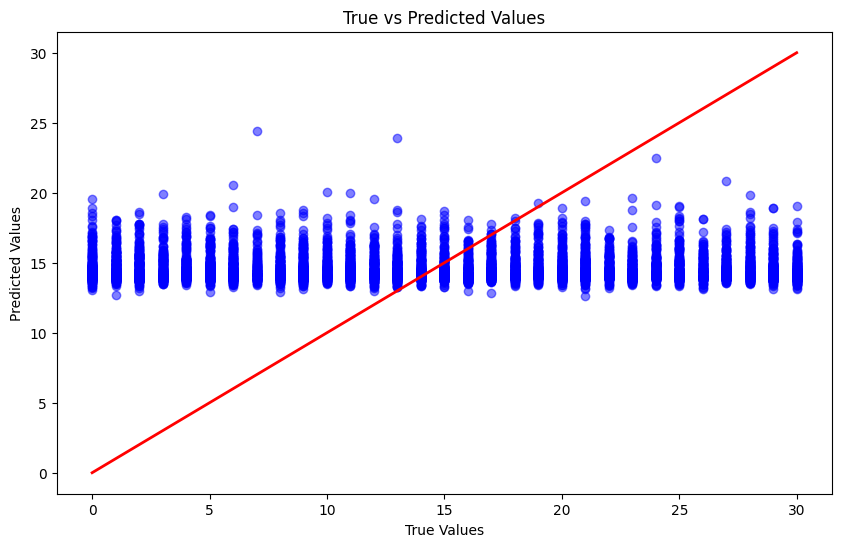

In [9]:
import matplotlib.pyplot as plt

# Plot true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, color='blue', alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linewidth=2)  # Line of perfect prediction
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()


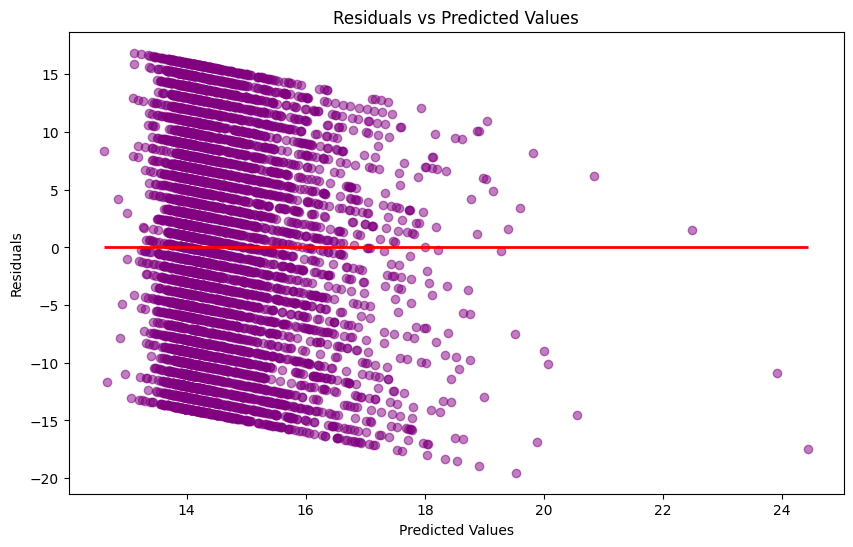

In [10]:
# Calculate residuals
residuals = y_true - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_pred.min(), y_pred.max(), color='red', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()


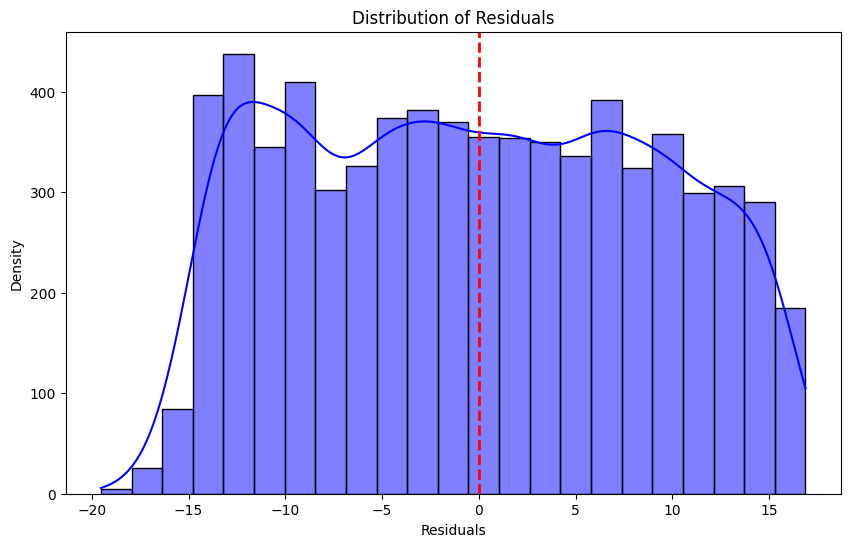

In [11]:
#2. Distribution of Errors (Histogram or KDE Plot)
import seaborn as sns

# Plot the distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)  # Reference line at 0
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Distribution of Residuals')
plt.show()


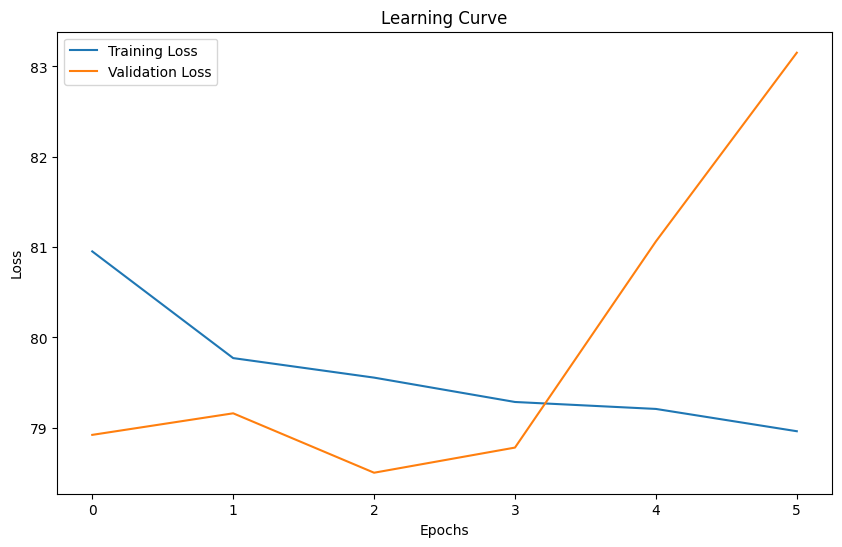

In [12]:
#3. Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()


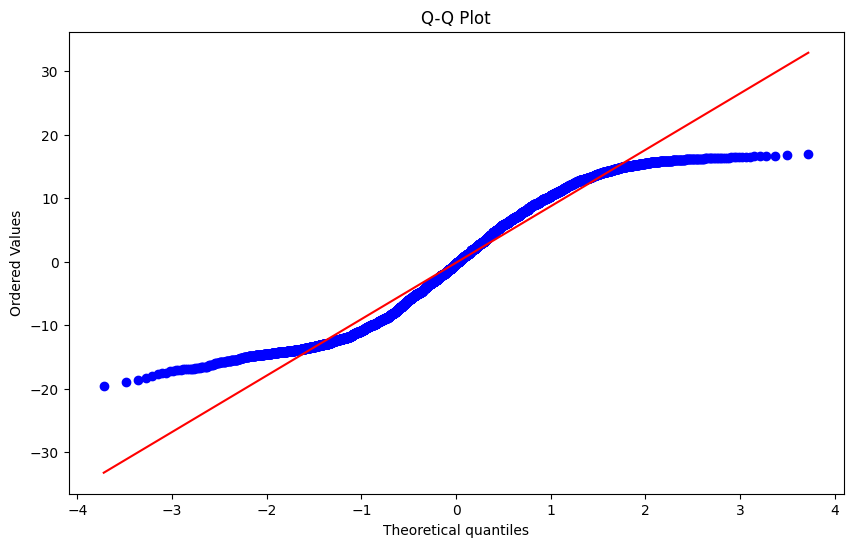

In [13]:
#4. Q-Q Plot (Quantile-Quantile Plot)
import scipy.stats as stats

# Q-Q plot
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()


In [14]:
#In regression tasks, "accuracy" isn't typically used in the same way as it
#is in classification tasks, where accuracy represents the percentage of
# correct predictions out of the total number of predictions. However, you can still
# derive a measure of how close your predictions are to the actual values, though
#it's not a straightforward "accuracy percentage" as in classification. Here are some
#methods you could consider to approximate this:

#1. Tolerance-Based Accuracy:
tolerance = 0.1  # 10% tolerance
accurate_predictions = np.sum(np.abs(y_pred - y_true) <= tolerance * y_true)
total_predictions = len(y_true)
accuracy = (accurate_predictions / total_predictions) * 100
print(f"Accuracy within {tolerance*100}% tolerance: {accuracy:.2f}%")


Accuracy within 10.0% tolerance: 9.46%


In [15]:
#2. R-squared as a Proxy for Accuracy:
from sklearn.metrics import r2_score

# Use r2_score from scikit-learn
r_squared = r2_score(y_test, y_pred)
accuracy_percentage = r_squared * 100                                 #not sure
print(f"R-squared accuracy: {accuracy_percentage:.2f}%")


NameError: name 'y_test' is not defined

In [16]:
#3. Mean Absolute Error Relative to Mean Value:
mae = np.mean(np.abs(y_pred - y_true))
mean_true = np.mean(y_true)
relative_accuracy = (1 - mae / mean_true) * 100
print(f"Relative MAE-based accuracy: {relative_accuracy:.2f}%")


Relative MAE-based accuracy: 45.87%


In [17]:
#4. Custom Accuracy Based on Thresholds:
threshold = 1  # For example, within ±1 year
accurate_predictions = np.sum(np.abs(y_pred - y_true) <= threshold)
total_predictions = len(y_true)
accuracy = (accurate_predictions / total_predictions) * 100
print(f"Accuracy within ±{threshold} unit: {accuracy:.2f}%")


Accuracy within ±1 unit: 6.25%


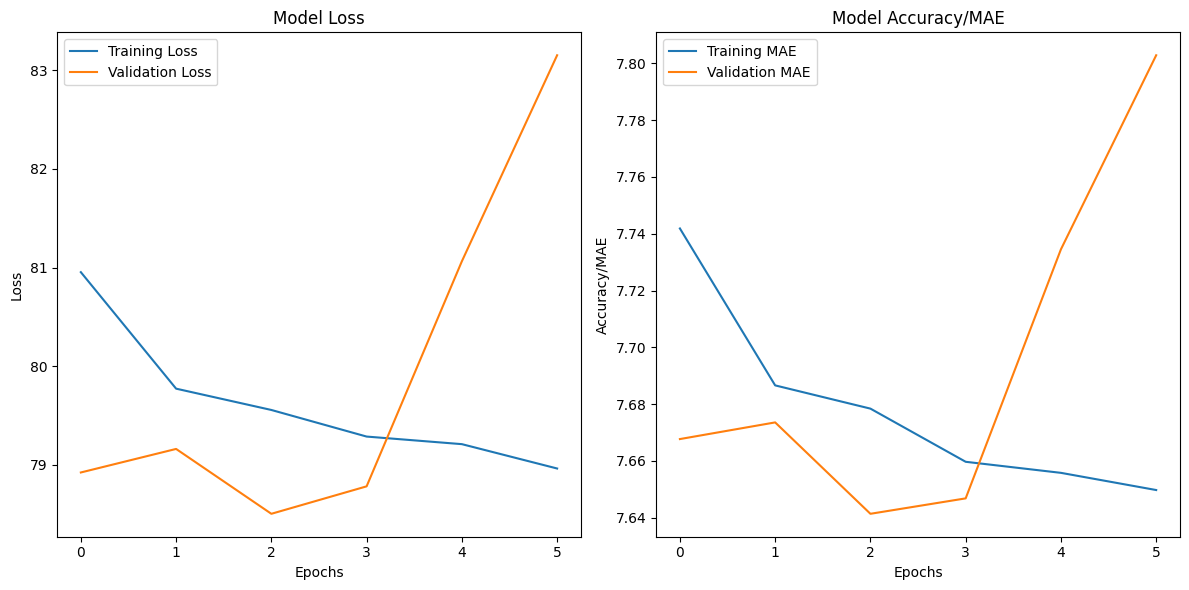

In [18]:
import matplotlib.pyplot as plt

# If you've calculated accuracy during training, you can plot it as follows:
# Assuming 'accuracy' is stored in the 'history' object:
# Note: In a regression task, replace accuracy with your specific custom metric if needed.

# Plotting Loss
plt.figure(figsize=(12, 6))

# Plot Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
elif 'mae' in history.history:
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/MAE')
plt.title('Model Accuracy/MAE')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted age: 31.623281478881836 years


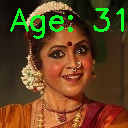

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from google.colab.patches import cv2_imshow  # Import cv2_imshow for displaying images in Colab

# Load the model from the .h5 file
model = tf.keras.models.load_model('/content/age_prediction_model_resnet.keras')

def predict_age(image_path):
    # Load the image
    img = cv2.imread(image_path)

    # Resize the image to the input size expected by the model
    img_resized = cv2.resize(img, (224, 224))  # ResNet typically uses 224x224 input size

    # Preprocess the image
    img_resized = preprocess_input(np.array(img_resized, dtype=np.float32))
    img_resized = np.expand_dims(img_resized, axis=0)  # Add batch dimension

    # Predict the age
    predicted_age = model.predict(img_resized)

    # Display the result
    print(f"Predicted age: {predicted_age[0][0]} years")

    # Optionally, show the image with the predicted age
    cv2.putText(img, f'Age: {int(predicted_age[0][0])}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (36, 255, 12), 2)
    cv2_imshow(img)  # Use cv2_imshow instead of cv2.imshow

# Test the function
predict_age('/content/50im2.jpg')  # Replace with your image path


In [19]:
#3epoch
# Model checkpoint to save best weights
checkpoint = ModelCheckpoint('best_model.weights.h5', monitor='val_mae', save_best_only=True, save_weights_only=True)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_mae', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=3,
    callbacks=[checkpoint, early_stopping]
)

# Load the best weights
model.load_weights('best_model.weights.h5')

Epoch 1/3
837/837 ━━━━━━━━━━━━━━━━━━━━ 95s 112ms/step - loss: 78.6703 - mae: 7.6323 - val_loss: 79.0177 - val_mae: 7.6624
Epoch 2/3
837/837 ━━━━━━━━━━━━━━━━━━━━ 93s 111ms/step - loss: 79.4267 - mae: 7.6691 - val_loss: 88.5900 - val_mae: 7.9560
Epoch 3/3
837/837 ━━━━━━━━━━━━━━━━━━━━ 95s 113ms/step - loss: 79.4502 - mae: 7.6675 - val_loss: 79.7900 - val_mae: 7.6723


In [20]:
from google.colab import files
model.save('age_prediction_model_resnet2_3epoch.keras')
# Download the model file
files.download('age_prediction_model_resnet2_3epoch.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
#Evaluate the model on the test set
test_loss, test_mae = model.evaluate(test_generator, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test MAE: {test_mae}')

219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - loss: 82.4578 - mae: 7.8450
Test Loss: 80.93033599853516
Test MAE: 7.761240005493164


In [22]:
#metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming y_true is your true labels and y_pred is your model's predictions
y_true = test_generator.classes  # True labels
y_pred = model.predict(test_generator).flatten()  # Flatten to match the shape of y_true

# Calculate regression metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

# Print metrics
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R² (Coefficient of Determination): {r2:.4f}')

219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step
Mean Absolute Error (MAE): 7.8776
Mean Squared Error (MSE): 83.4721
Root Mean Squared Error (RMSE): 9.1363
R² (Coefficient of Determination): -0.0305


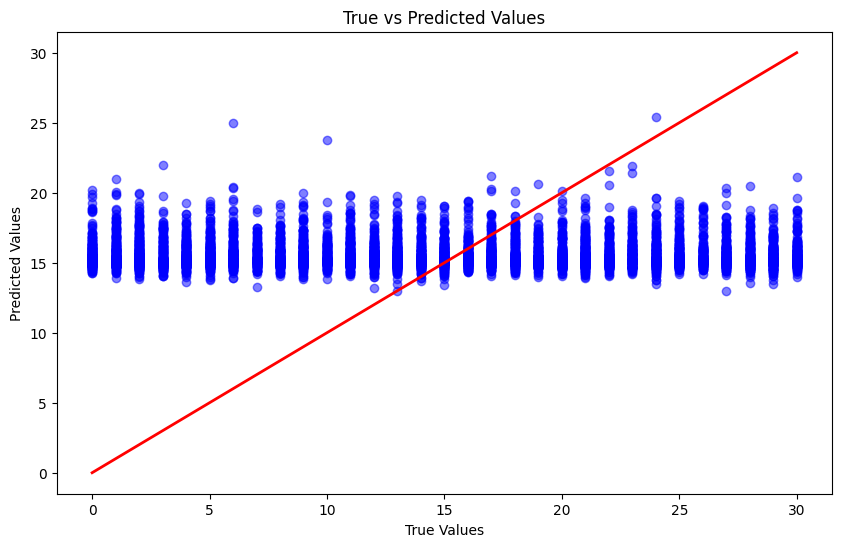

In [23]:
import matplotlib.pyplot as plt

# Plot true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, color='blue', alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linewidth=2)  # Line of perfect prediction
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()


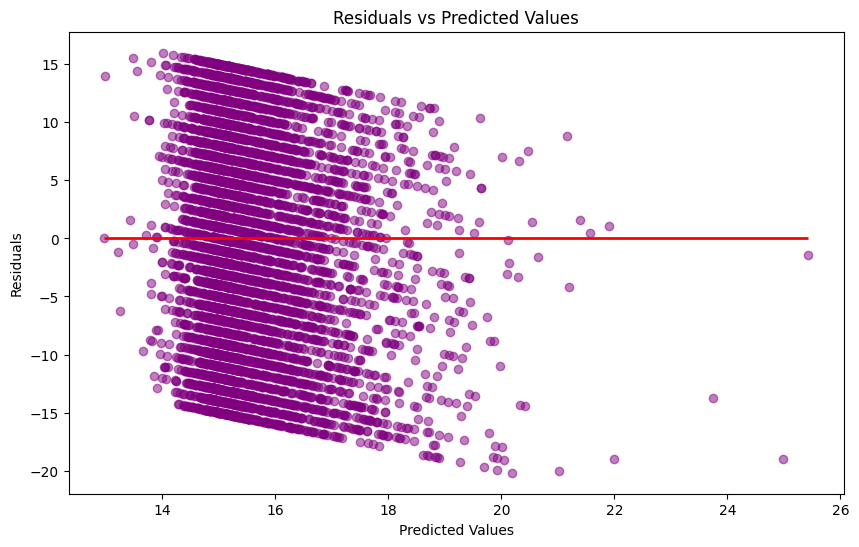

In [24]:
# Calculate residuals
residuals = y_true - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_pred.min(), y_pred.max(), color='red', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()


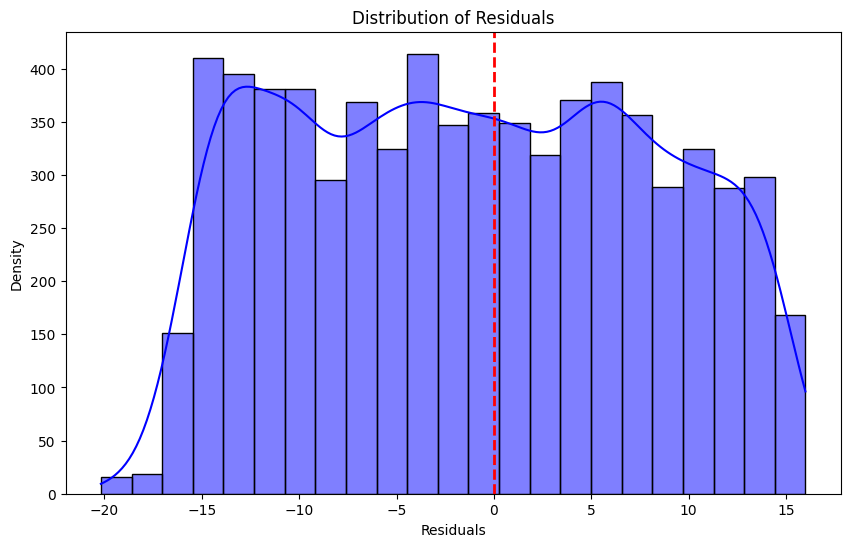

In [25]:
#2. Distribution of Errors (Histogram or KDE Plot)
import seaborn as sns

# Plot the distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)  # Reference line at 0
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Distribution of Residuals')
plt.show()


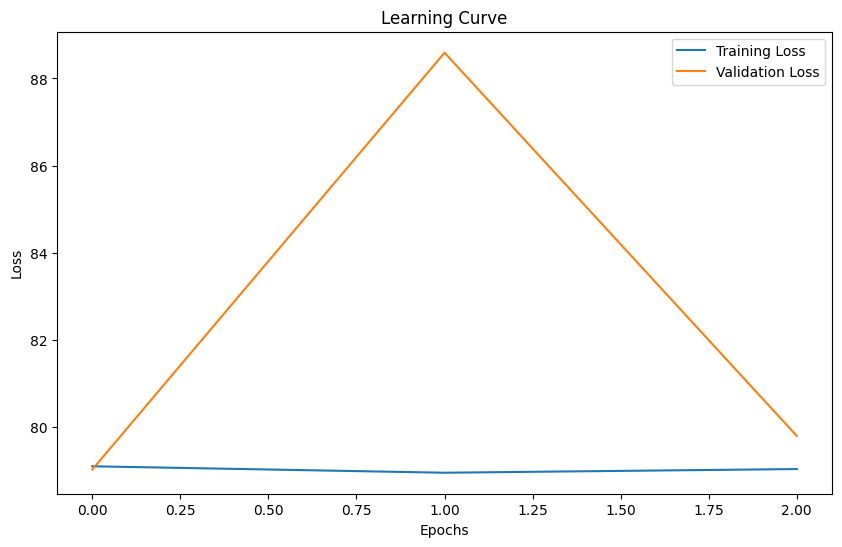

In [26]:
#3. Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()


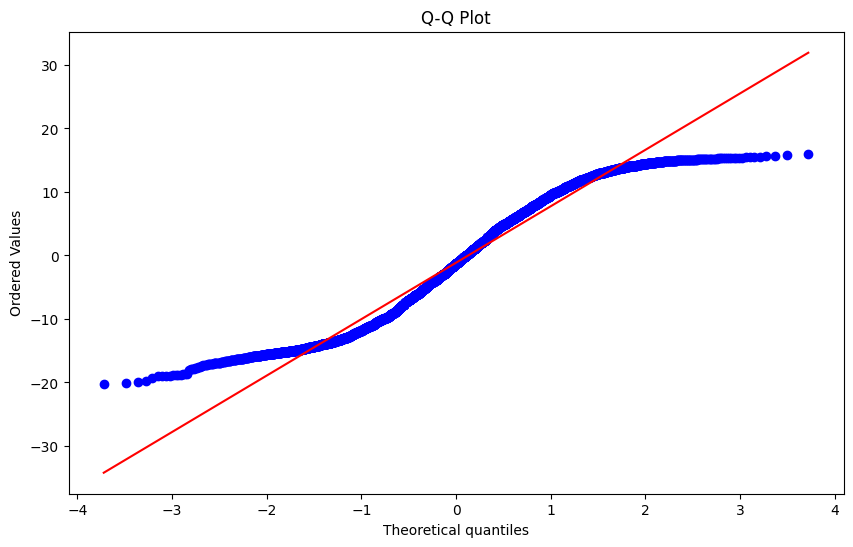

In [27]:
#4. Q-Q Plot (Quantile-Quantile Plot)
import scipy.stats as stats

# Q-Q plot
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()


In [28]:
#In regression tasks, "accuracy" isn't typically used in the same way as it
#is in classification tasks, where accuracy represents the percentage of
# correct predictions out of the total number of predictions. However, you can still
# derive a measure of how close your predictions are to the actual values, though
#it's not a straightforward "accuracy percentage" as in classification. Here are some
#methods you could consider to approximate this:

#1. Tolerance-Based Accuracy:
tolerance = 0.1  # 10% tolerance
accurate_predictions = np.sum(np.abs(y_pred - y_true) <= tolerance * y_true)
total_predictions = len(y_true)
accuracy = (accurate_predictions / total_predictions) * 100
print(f"Accuracy within {tolerance*100}% tolerance: {accuracy:.2f}%")


Accuracy within 10.0% tolerance: 10.33%


In [29]:
#3. Mean Absolute Error Relative to Mean Value:
mae = np.mean(np.abs(y_pred - y_true))
mean_true = np.mean(y_true)
relative_accuracy = (1 - mae / mean_true) * 100
print(f"Relative MAE-based accuracy: {relative_accuracy:.2f}%")


Relative MAE-based accuracy: 45.45%


In [30]:
#4. Custom Accuracy Based on Thresholds:
threshold = 1  # For example, within ±1 year
accurate_predictions = np.sum(np.abs(y_pred - y_true) <= threshold)
total_predictions = len(y_true)
accuracy = (accurate_predictions / total_predictions) * 100
print(f"Accuracy within ±{threshold} unit: {accuracy:.2f}%")


Accuracy within ±1 unit: 6.35%


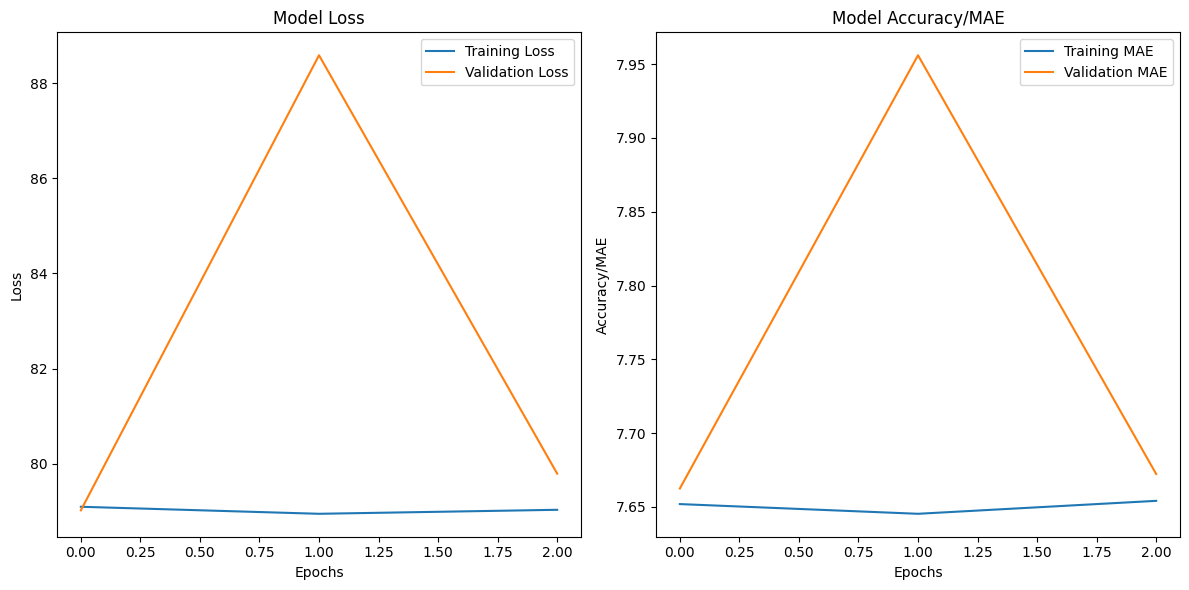

In [32]:
import matplotlib.pyplot as plt

# If you've calculated accuracy during training, you can plot it as follows:
# Assuming 'accuracy' is stored in the 'history' object:
# Note: In a regression task, replace accuracy with your specific custom metric if needed.

# Plotting Loss
plt.figure(figsize=(12, 6))

# Plot Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
elif 'mae' in history.history:
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/MAE')
plt.title('Model Accuracy/MAE')
plt.legend()

plt.tight_layout()
plt.show()


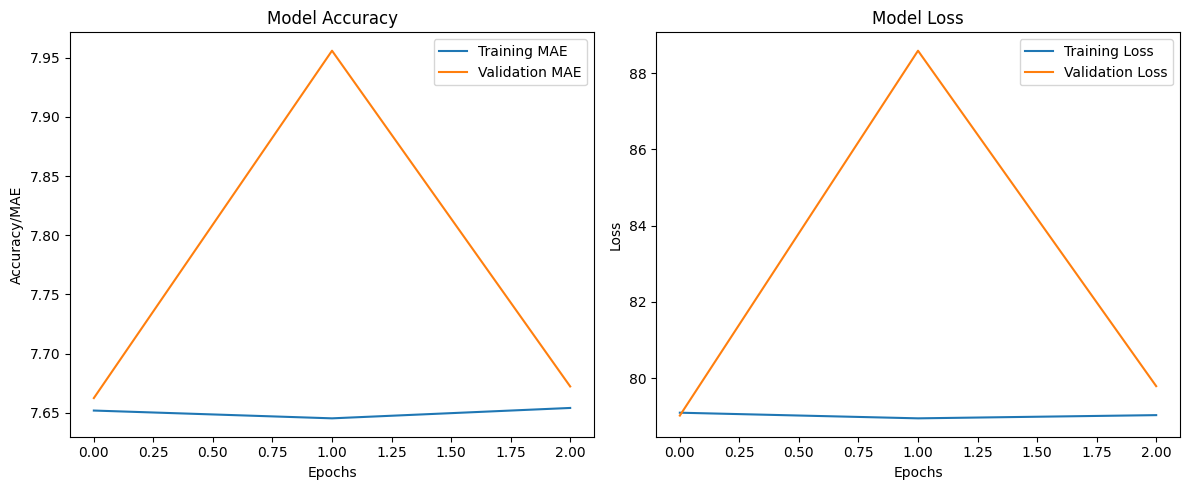

In [33]:
#gopi code graph
import matplotlib.pyplot as plt

# Plotting Model Accuracy
plt.figure(figsize=(12, 5))

# Model Accuracy Plot
plt.subplot(1, 2, 1)
if 'accuracy' in history.history:  # For classification tasks
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
elif 'mae' in history.history:  # For regression tasks using MAE as a proxy for accuracy
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
else:
    raise ValueError("No accuracy or MAE metric found in history.")
plt.xlabel('Epochs')
plt.ylabel('Accuracy/MAE')
plt.title('Model Accuracy')
plt.legend()

# Model Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.show()


Some of the best accuracy metrics for regression tasks include:

Mean absolute error (MAE)
The average of the sum of all the absolute values of the error. MAE is a good metric to use when there are outliers in the data.

Mean squared error (MSE)
The average of the squared difference between the target value and the value predicted by the regression model. A lower MSE indicates better performance.

Root mean squared error (RMSE)
The square root of the averaged squared difference between the target value and the value predicted by the model. RMSE is a good measure of accuracy, but it's not recommended for comparing predictions.

Adjusted r²
A reliable measure of model performance that accounts for the trade-off between model complexity and goodness of fit. It's especially useful when comparing regression models with different numbers of features.